In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anti-uav-yolo-1024/valid/labels/01028.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01484.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00588.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00286.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00080.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01279.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00440.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02557.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01936.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00733.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00134.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01466.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00709.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00372.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01850.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02017.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02363.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01

In [2]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

In [3]:
from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

import glob
import cv2
from PIL import Image

In [4]:
BASE_PATH = "/kaggle/input/anti-uav-yolo-1024/train"
TXT_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/labels/*.txt")
IMG_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/images/*.jpg")

In [5]:
def convert_format(box, iwidth=1024, iheight=1024):
    x_center, y_center, width, height = box
    
    x_min = int((x_center - width / 2) * iwidth)
    y_min = int((y_center - height / 2) * iheight)
    x_max = int((x_center + width / 2) * iwidth)
    y_max = int((y_center + height / 2) * iheight)
    
    return [x_min, y_min, x_max, y_max]

In [6]:
import os
from PIL import Image

train_image = []
train_image_path = []
train_image_id = []
train_annotation = []

for img_path in IMG_PATH:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/train/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((258, 258))
            train_image.append(np.asarray(nmpy_img))
            train_image_path.append(img_path)
            train_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                train_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")


Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00639.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00724.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00579.jpg
Images and annotations processed successfully.


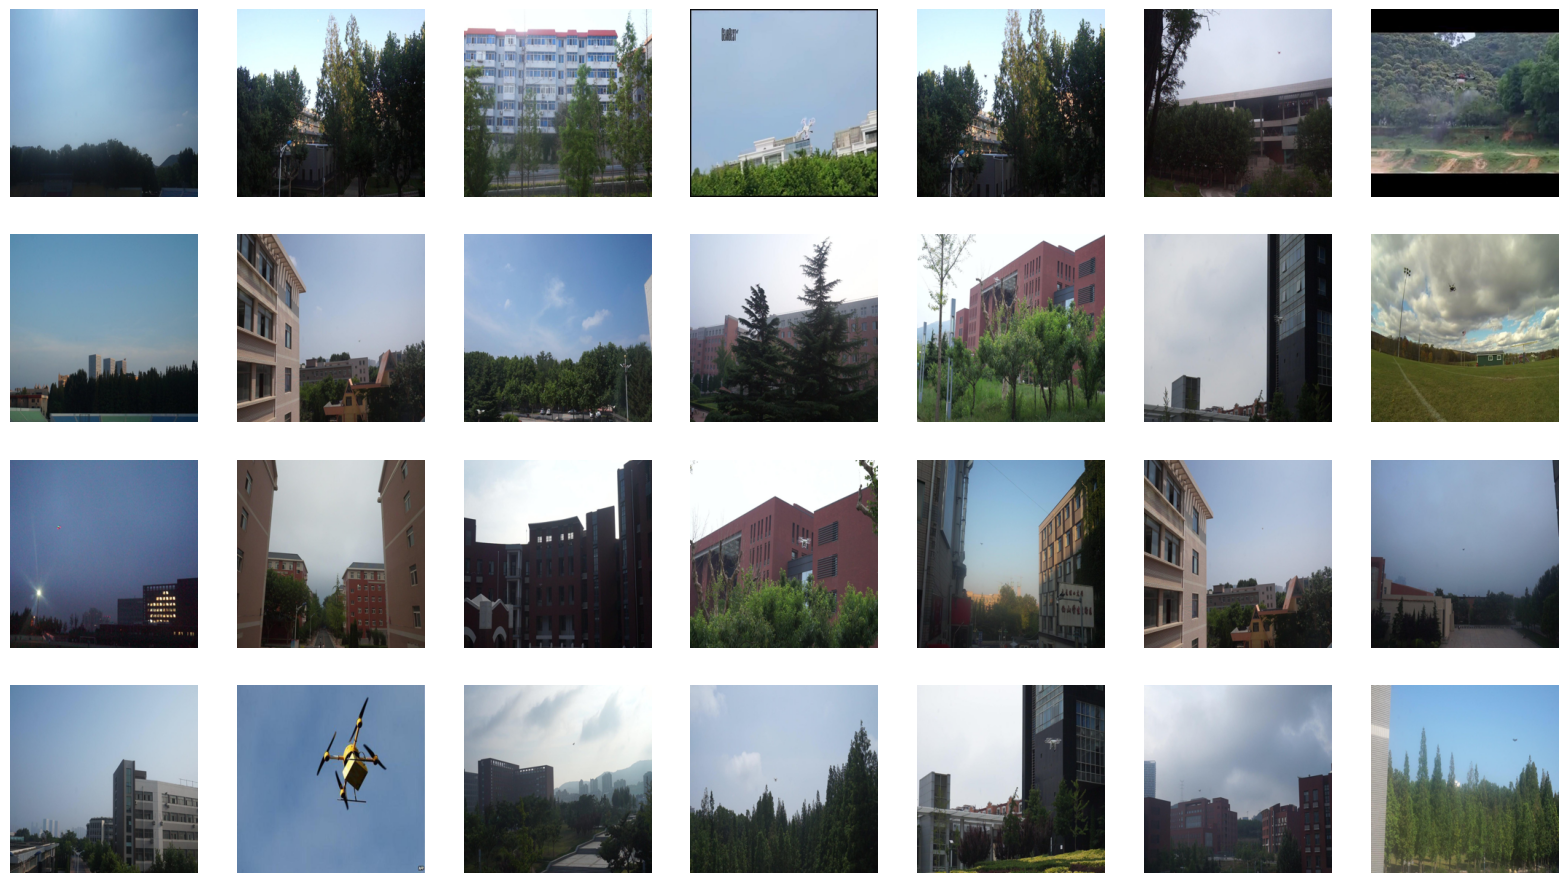

In [7]:
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

In [8]:
df = pd.DataFrame()
df['boxes'] = train_annotation
df['img_path'] = train_image_path
df['labels'] = 'drone'
df['img_id'] = train_image_id

In [9]:
import numpy as np
from sklearn import preprocessing

enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['labels'])
df['labels'] = np.stack([df['labels'][i]+1 for i in range(len(df['labels']))])

In [10]:
import numpy as np

# Assuming df['boxes'] contains arrays/lists of coordinates
# Create separate columns for 'xmin', 'ymin', 'xmax', 'ymax'
df[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(float)
df['ymin'] = df['ymin'].astype(float)
df['xmax'] = df['xmax'].astype(float)
df['ymax'] = df['ymax'].astype(float)

In [11]:
df_removed_damaged = df.drop(df[(df.ymin > df.ymax) | (df.xmin > df.xmax)].index)
df_removed_damaged

img_path  labels img_id   xmin  \
0     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04168  566.0   
1     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02371  296.0   
2     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04377  469.0   
3     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  00767  576.0   
4     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02360  361.0   
...                                                 ...     ...    ...    ...   
5192  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02956  489.0   
5193  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04731  505.0   
5194  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  03358  157.0   
5195  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04801   64.0   
5196  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  00117  170.0   

       ymin   xmax   ymax  
0     703.0  580.0  714.0  
1     360.0  318.0  383.0  
2     381.0  481.0  390.0  
3     594.0  682.0  716.0  
4     352.0  388.0  381.0  
...     ...    ...    ...  
5192  612.0  505.0  633.0  
5193  615.0  522.0  629.0  
5194  713.0  190.0  738.0  
5195  513.0   80.0  521.0  
5196  526.0  626.0  875.0  

[5197 rows x 7 columns]

In [12]:
train_ds=df_removed_damaged[:4000]
val_ds=df_removed_damaged[4000:]
train_ds

img_path  labels img_id   xmin  \
0     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04168  566.0   
1     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02371  296.0   
2     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04377  469.0   
3     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  00767  576.0   
4     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02360  361.0   
...                                                 ...     ...    ...    ...   
3995  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02303  607.0   
3996  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02648  477.0   
3997  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  03674  322.0   
3998  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02833  192.0   
3999  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  00457  333.0   

       ymin   xmax   ymax  
0     703.0  580.0  714.0  
1     360.0  318.0  383.0  
2     381.0  481.0  390.0  
3     594.0  682.0  716.0  
4     352.0  388.0  381.0  
...     ...    ...    ...  
3995  420.0  627.0  436.0  
3996  747.0  500.0  775.0  
3997  659.0  340.0  678.0  
3998  858.0  242.0  900.0  
3999  500.0  485.0  689.0  

[4000 rows x 7 columns]

In [25]:
class TrainDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.resize(image, (1024, 1024))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        if len(boxes) == 0:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'image_id': torch.tensor([index]),
                'area': torch.zeros(0, dtype=torch.float32),
                'iscrowd': torch.zeros(0, dtype=torch.int64)
            }
        else:
            # Normalize bounding box coordinates
            boxes[:, [0, 2]] /= cols  # Normalize x coordinates
            boxes[:, [1, 3]] /= rows  # Normalize y coordinates

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            label = records['labels'].values
            labels = torch.as_tensor(label, dtype=torch.int64)

            # Suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([index]),
                'area': area,
                'iscrowd': iscrowd
            }

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

            # Only stack the boxes if there are non-empty bounding boxes
            if len(sample['bboxes']) > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]


In [14]:
def get_transform_train():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = TrainDataset(train_ds, '/kaggle/input/anti-uav-yolo-1024/train/images', get_transform_train())
valid_dataset = TrainDataset(val_ds, '/kaggle/input/anti-uav-yolo-1024/train/images', get_transform_valid())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

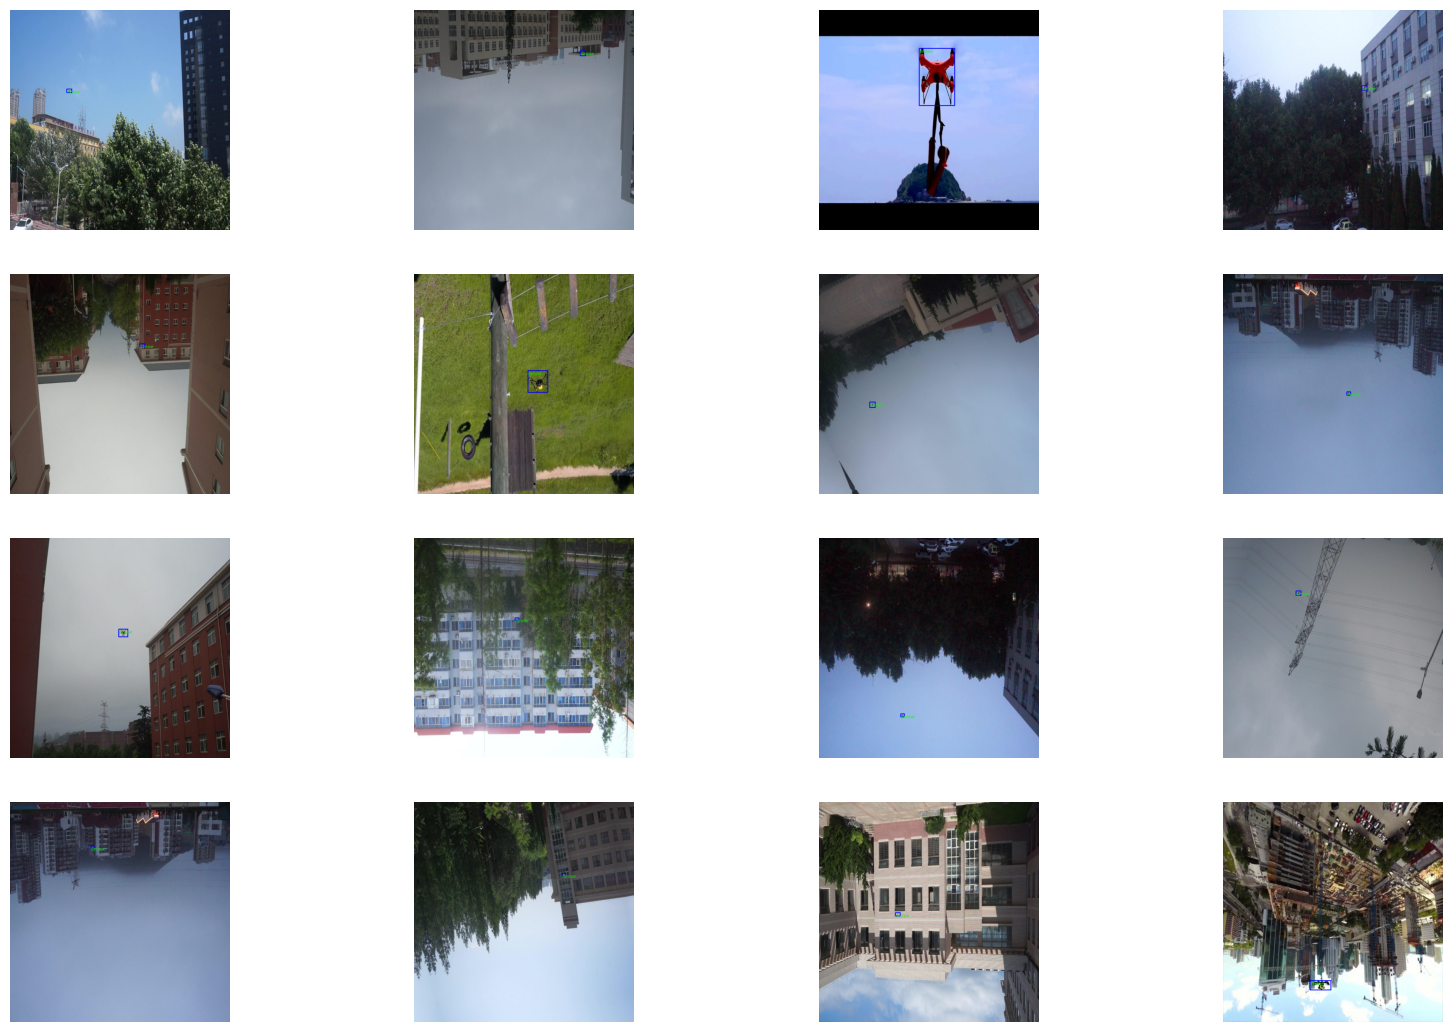

In [18]:
classes= {1:'drone'}

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(6,4, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy() * 255
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

In [19]:
fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 140MB/s]  


In [20]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (drone) + background
# get number of input features for the classifier
in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [21]:
fasterrcnn.to(device)
optimizer = torch.optim.SGD(fasterrcnn.parameters(), lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01)

In [27]:
from tqdm import tqdm
def train_epoch(model, train_data, optim, n_epoch):
    model.train()
    batches_loss = 0
    writer = list()
    len_train_sample = len(train_data)
    epoch_loss = 0
    print(f"Epoch #{n_epoch} started!\n")
    print(f"----------------------------Train started!----------------------------")
    for batch in tqdm(train_data):
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optim.zero_grad()
        losses = model(imgs, targets)
        loss = sum(loss for loss in losses.values())
        writer.append(loss/len(batch))
        batches_loss += writer[-1]
        loss.backward()
        optim.step()
        #print(f"Mean batch loss: {writer[-1]}")
    epoch_loss = batches_loss/len_train_sample
    print(f"Mean epoch loss: {epoch_loss}\n----------------------------\n")
    return epoch_loss, writer

In [28]:
@torch.no_grad()
def validate_epoch(model, val_data, optim):
    model.train()
    writer = list()
    len_val_sample = len(val_data)
    batches_loss = 0
    print(f"----------------------------Validate started!----------------------------")
    for batch in val_data:
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optim.zero_grad()
        losses = model(imgs, targets)
        loss = sum(loss for loss in losses.values())
        writer.append(loss/len(batch))
        batches_loss += writer[-1]
        #print(f"Mean batch loss: {writer[-1]}")
    epoch_loss = batches_loss/len_val_sample
    print(f"Mean epoch loss: {epoch_loss}\n----------------------------\n")
    return epoch_loss, writer

In [31]:
epochs = 5
train_loss = list()
val_loss = list()
iter_train_loss = list()
iter_val_loss = list()

for epoch in range(epochs):
    tr_loss, it_tr_loss = train_epoch(fasterrcnn, train_data_loader, optimizer, epoch)
    train_loss.append(tr_loss.to("cpu"))
    iter_train_loss.extend([i.to("cpu").item() for i in it_tr_loss])
    vl_loss, it_vl_loss = validate_epoch(fasterrcnn, valid_data_loader, optimizer)
    val_loss.append(vl_loss.to("cpu"))
    iter_val_loss.extend([i.to("cpu").item() for i in it_vl_loss])

Epoch #0 started!

----------------------------Train started!----------------------------


  0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_35/1981203926.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
100%|██████████| 250/250 [06:12<00:00,  1.49s/it]


Mean epoch loss: 0.11320628439534036
----------------------------

----------------------------Validate started!----------------------------


/tmp/ipykernel_35/3035759325.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Mean epoch loss: 0.2077736373199014
----------------------------

Epoch #1 started!

----------------------------Train started!----------------------------


100%|██████████| 250/250 [06:11<00:00,  1.49s/it]


Mean epoch loss: 0.09471398831411554
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.21839116639420625
----------------------------

Epoch #2 started!

----------------------------Train started!----------------------------


100%|██████████| 250/250 [06:11<00:00,  1.49s/it]


Mean epoch loss: 0.08997228354452677
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.2575664790083098
----------------------------

Epoch #3 started!

----------------------------Train started!----------------------------


  0%|          | 1/250 [00:03<12:42,  3.06s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a07dfb17d00>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a07dfb17d00>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
      File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_ali

Mean epoch loss: 0.09109316867502393
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.19715124448359195
----------------------------

Epoch #4 started!

----------------------------Train started!----------------------------


100%|██████████| 250/250 [06:10<00:00,  1.48s/it]


Mean epoch loss: 0.08851484686789796
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.24581979778109236
----------------------------



In [45]:
train_loss

[tensor(0.1132, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0947, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0900, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0911, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0885, dtype=torch.float64, grad_fn=<ToCopyBackward0>)]

In [46]:
val_loss

[tensor(0.2078, dtype=torch.float64),
 tensor(0.2184, dtype=torch.float64),
 tensor(0.2576, dtype=torch.float64),
 tensor(0.1972, dtype=torch.float64),
 tensor(0.2458, dtype=torch.float64)]

In [35]:
trainloss = [tensor.item() for tensor in train_loss]
valloss= [tensor.item() for tensor in val_loss]

In [43]:
print(trainloss)

[0.11320628439534036, 0.09471398831411554, 0.08997228354452677, 0.09109316867502393, 0.08851484686789796]


In [44]:
print(valloss)

[0.2077736373199014, 0.21839116639420625, 0.2575664790083098, 0.19715124448359195, 0.24581979778109236]


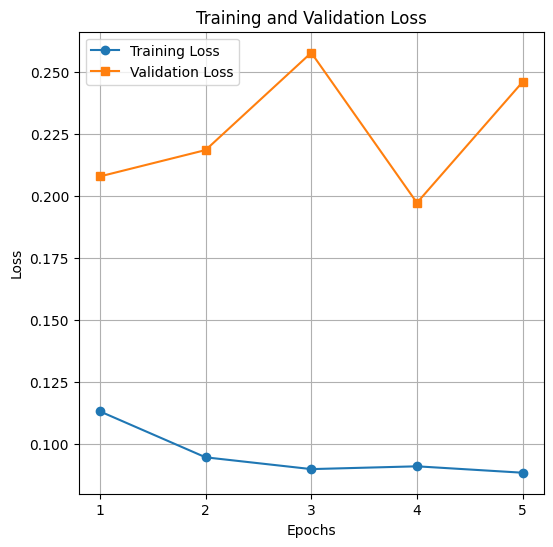

In [39]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(6, 6))
plt.plot(range(1, epochs+1), trainloss, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), valloss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(range(1, epochs+1))
plt.legend()
plt.grid(True)
plt.show()

In [41]:
"""torch.save(fasterrcnn, 'model.pth')"""

In [42]:
"""torch.save(fasterrcnn.state_dict(), 'model_state_dict.pth')"""

In [47]:
"""with open('loss_values.txt', 'w') as file:
    file.write('Train Loss\n')
    for item in trainloss:
        file.write(f'{item}\n')
    file.write('\n')
    file.write('Validation Loss\n')
    for item in valloss:
        file.write(f'{item}\n')"""